In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -U pytorch-nlp
!pip install -U torchtext
!pip install -U torchdata
!pip install -U scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 KB 10.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 100.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 13.3 MB/s eta 0:00

In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
import matplotlib.pyplot as plt
import re
import string
import torch.nn as nn

from collections import Counter

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset
import torch

import math

from torch import nn
from torch.nn import functional as F

from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

from torch.optim import Adam, SGD

from sklearn.metrics import confusion_matrix
import scikitplot as skplt

In [5]:
username_pattern = "@[^\s]+"
emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"
                        u"\U0001F300-\U0001F5FF"
                        u"\U0001F680-\U0001F6FF"
                        u"\U0001F1E0-\U0001F1FF"
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        "]+", flags=re.UNICODE)
url_pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
multi_chars   = r"(.)\1\1+"
replace_multi_chars = r"\1\1"
delete_dict = {sp_character: '' for sp_character in string.punctuation}
delete_dict[' '] = ' '
table = str.maketrans(delete_dict)

In [6]:
def preprocess(text):
    text = clean_text(text)
    text = emoji_pattern.sub(r'', text)
    text = url_pattern.sub(r'', text)
    text = re.sub(username_pattern, " USER", text)
    text = re.sub(multi_chars, replace_multi_chars, text)
    return text

In [7]:
def get_all_data():
    d1 = pd.read_csv("./twitter_training.csv", names=['id','topic','sentiment','content'])
    d2 = pd.read_csv("./twitter_validation.csv", names=['id','topic','sentiment','content'])
    d3 = pd.concat([d1, d2], ignore_index=True)
    d4 = d3.drop(['id', 'topic'], axis=1)
    data_twitter = d4[(d4['sentiment'] == 'Positive') | (d4['sentiment'] == 'Negative')]
    data_twitter = data_twitter.rename(columns={'content': 'text'})
    data_twitter['sentiment'] = data_twitter['sentiment'].apply(lambda x: int(x == 'Positive'))
    data_twitter = data_twitter[['text', 'sentiment']]

    d1 = pd.read_csv("./train.csv")
    d2 = pd.read_csv("./test.csv")
    d1 = d1.drop('selected_text', axis=1)
    d3 = pd.concat([d1, d2], ignore_index=True)
    d3 = d3.drop('textID', axis=1)
    tweet_data = d3[(d3['sentiment'] == 'positive') | (d3['sentiment'] == 'negative')]
    tweet_data['sentiment'] = tweet_data['sentiment'].apply(lambda x: int(x == 'positive'))
    tweet_data = tweet_data[['text', 'sentiment']]

    d1 = pd.read_csv("./sentiment140_with_location.csv", names=["sentiment", "tweetID", "date", "query_flag", "user", "text", "location"])
    sentiment_data = d1[['text', 'sentiment']]
    sentiment_data['sentiment'] = sentiment_data['sentiment'].apply(lambda x: 1 if x else 0)

    return pd.concat([sentiment_data, data_twitter, tweet_data], ignore_index=True)

In [8]:
data = get_all_data()

<ipython-input-7-5b96d03fd3de>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_data['sentiment'] = tweet_data['sentiment'].apply(lambda x: int(x == 'positive'))
<ipython-input-7-5b96d03fd3de>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_data['sentiment'] = sentiment_data['sentiment'].apply(lambda x: 1 if x else 0)


In [9]:
max_tokens = 64
batch_size = 1024
embed_len = 128

target_classes = {0: 'negative' , 1: 'positive'}

def remove_usernames(text):
    return re.sub(username_pattern, " USER", text)

def remove_multi_chars(text):
    return re.sub(multi_chars, replace_multi_chars, text)

def remove_emoji(text):
    return emoji_pattern.sub(r'', text)


def remove_url(text):
    return url_pattern.sub(r'', text)


def clean_text(text):
    text_1 = text.translate(table)
    words = text_1.split()
    text2 = ' '.join([w for w in words if (not w.isdigit() and (not w.isdigit() and len(w) > 2))])

    return text2.lower()


In [10]:
train_data, test_data = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=True)

train_data.dropna(axis=0, how='any', inplace=True)
train_data['Num_words_text'] = train_data['text'].apply(lambda x: len(str(x).split()))
mask = train_data['Num_words_text'] > 2
train_data = train_data[mask]
print('------- Training data--------')
print(train_data['sentiment'].value_counts())
print(len(train_data))
print('-------------------------')
max_train_sentence_length = train_data['Num_words_text'].max()

train_data['text'] = train_data['text'].apply(preprocess)

------- Training data--------
0    653518
1    648597
Name: sentiment, dtype: int64
1302115
-------------------------


In [11]:
test_data['Num_words_text'] = test_data['text'].apply(lambda x: len(str(x).split()))

max_test_sentence_length = test_data['Num_words_text'].max()

mask = test_data['Num_words_text'] > 2
test_data = test_data[mask]

print('------- Test data--------')
print(test_data['sentiment'].value_counts())
print(len(test_data))
print('-------------------------')


test_data['text'] = test_data['text'].apply(preprocess)
train_data['sentiment'] = train_data['sentiment'].apply(lambda x: 1 if x else 0)
test_data['sentiment'] = test_data['sentiment'].apply(lambda x: 1 if x else 0)

print('Train Max Sentence Length :' + str(max_train_sentence_length))
print('Test Max Sentence Length :' + str(max_test_sentence_length))

train_data['text'].tolist()[:5]

------- Test data--------
0    163091
1    162424
Name: sentiment, dtype: int64
325515
-------------------------
Train Max Sentence Length :198
Test Max Sentence Length :198


['playin wit new fone',
 'love you thomasi will always respect and support your decisionand ill miss you but youre gonna amazing things you',
 'another sleepless night time get some zz',
 'marksandspencer all heart mamps',
 'stacijansma bet will awesome still waiting for the day that dsl will available where live']

In [12]:
"""Tokenizing"""

train_dataset = train_data[['sentiment', 'text']].values.tolist()
test_dataset = test_data[['sentiment', 'text']].values.tolist()


tokenizer = get_tokenizer("basic_english")


def build_vocab(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)


vocab = build_vocab_from_iterator(build_vocab([train_dataset, test_dataset]), specials=["<UNK>"], min_freq=5)
vocab.set_default_index(vocab["<UNK>"])
tokens = tokenizer("thingsofthesky feel all the way round everythings changing here and people thought knew are not what thought")
indexes = vocab(tokens)

tokens, indexes

(['thingsofthesky',
  'feel',
  'all',
  'the',
  'way',
  'round',
  'everythings',
  'changing',
  'here',
  'and',
  'people',
  'thought',
  'knew',
  'are',
  'not',
  'what',
  'thought'],
 [0, 76, 16, 1, 99, 942, 3545, 2073, 62, 2, 111, 212, 645, 20, 11, 36, 212])

In [13]:
len(vocab)

87086

In [14]:
def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab(tokenizer(sample)) for sample in X]
    X = [([0] * math.ceil((max_tokens - len(sample))/2)) + sample + ([0] * math.floor((max_tokens - len(sample))/2)) if len(sample) < max_tokens else sample[:max_tokens] for sample in
         X]
    return torch.tensor(X, dtype=torch.int32), torch.tensor(Y)


map_train_dataset, map_test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)


train_loader = DataLoader(map_train_dataset, batch_size=batch_size, collate_fn=vectorize_batch, shuffle=True)
test_loader = DataLoader(map_test_dataset, batch_size=batch_size, collate_fn=vectorize_batch)

for X, Y in train_loader:
    print(X.shape, Y.shape)
    break



torch.Size([1024, 64]) torch.Size([1024])


In [15]:
class Conv1DSentimentAnalysis(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, hidden_dim, num_classes):
        super(Conv1DSentimentAnalysis, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        
        self.fc = nn.Linear(len(filter_sizes) * num_filters, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.out = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        
        x = [self.relu(conv(x)) for conv in self.convs]
        x = [torch.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in x]
        x = torch.cat(x, dim=1)
        
        x = self.fc(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.out(x)
        
        return x


In [16]:
class RNNClassifier(nn.Module):
    def __init__(self):
        super(RNNClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.rnn1 = nn.RNN(input_size=64, hidden_size=64, num_layers=3, nonlinearity='relu')
        self.pooling = nn.MaxPool1d(1)
        self.linear = nn.Linear(128, 2)

    def forward(self, X_batch):
        x = self.embedding_layer(X_batch)
        x = x.reshape(len(x), embed_len, max_tokens)
        x, _ = self.rnn1(x)
        x = self.pooling(x)
        x, _ = x.max(dim=-1)
        x = torch.sigmoid(self.linear(x))
        return x

In [17]:
def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            X, Y = X.to(device), Y.to(device)
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        v_loss = torch.tensor(losses).mean()
        print("Valid Loss : {:.5f}".format(v_loss))
        print("Valid Acc  : {:.5f}".format(accuracy_score(Y_shuffled.cpu().detach().numpy(), Y_preds.cpu().detach().numpy())))
        return v_loss


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    train_loss = []
    valid_loss = []
    for i in range(1, epochs+1):
        losses = []
        print(f"Epoch {i}:")
        for X, Y in tqdm(train_loader):
            X, Y = X.to(device), Y.to(device)
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        t_loss = torch.tensor(losses).mean()
        train_loss.append(t_loss)
        print("Train Loss : {:.5f}".format(t_loss))
        valid_loss.append(CalcValLossAndAccuracy(model, loss_fn, val_loader))
    return train_loss, valid_loss

In [18]:
def get_model_layers(model):
    for layer in model.children():
        print("Layer : {}".format(layer))
        print("Parameters : ")
        for param in layer.parameters():
            print(param.shape)
        print()

    inp = torch.randint(0, len(vocab), (batch_size, max_tokens)).to(device)

    out = model(inp)

    print(out.shape)

In [30]:
def train(model):
    epochs = 50
    learning_rate = 0.0005

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=0.0005)

    return TrainModel(model, loss_fn, optimizer, train_loader, test_loader, epochs)


In [31]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        X, Y = X.to(device), Y.to(device)
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.cpu().detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).cpu().detach().numpy()

In [32]:
def plot_losses(t, v):
    x = list(range(1, len(t)+1))
    tr = [i.item() for i in t]
    va = [i.item() for i in v]
    plt.plot(x, tr, label ='training loss')
    plt.plot(x, va, '-.', label ='validation loss')

    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.title('Loss vs Epochs')
    plt.show()

In [33]:
def exec_pipeline(model):
    get_model_layers(model)
    train_loss, valid_loss = train(model)
    plot_losses(train_loss, valid_loss)
    return train_loss, valid_loss

#CNN

Layer : Embedding(87086, 128)
Parameters : 
torch.Size([87086, 128])

Layer : ModuleList(
  (0): Conv1d(128, 100, kernel_size=(3,), stride=(1,))
  (1): Conv1d(128, 100, kernel_size=(4,), stride=(1,))
  (2): Conv1d(128, 100, kernel_size=(5,), stride=(1,))
)
Parameters : 
torch.Size([100, 128, 3])
torch.Size([100])
torch.Size([100, 128, 4])
torch.Size([100])
torch.Size([100, 128, 5])
torch.Size([100])

Layer : Linear(in_features=300, out_features=128, bias=True)
Parameters : 
torch.Size([128, 300])
torch.Size([128])

Layer : ReLU()
Parameters : 

Layer : Dropout(p=0.5, inplace=False)
Parameters : 

Layer : Linear(in_features=128, out_features=2, bias=True)
Parameters : 
torch.Size([2, 128])
torch.Size([2])

torch.Size([1024, 2])
Epoch 1:


100%|██████████| 1272/1272 [01:10<00:00, 18.10it/s]


Train Loss : 0.51163
Valid Loss : 0.47404
Valid Acc  : 0.77370
Epoch 2:


100%|██████████| 1272/1272 [01:09<00:00, 18.26it/s]


Train Loss : 0.46535
Valid Loss : 0.46822
Valid Acc  : 0.77735
Epoch 3:


100%|██████████| 1272/1272 [01:08<00:00, 18.49it/s]


Train Loss : 0.45485
Valid Loss : 0.46567
Valid Acc  : 0.77930
Epoch 4:


100%|██████████| 1272/1272 [01:09<00:00, 18.32it/s]


Train Loss : 0.44685
Valid Loss : 0.45213
Valid Acc  : 0.78941
Epoch 5:


100%|██████████| 1272/1272 [01:09<00:00, 18.39it/s]


Train Loss : 0.43377
Valid Loss : 0.43181
Valid Acc  : 0.80194
Epoch 6:


100%|██████████| 1272/1272 [01:08<00:00, 18.48it/s]


Train Loss : 0.42148
Valid Loss : 0.42229
Valid Acc  : 0.80722
Epoch 7:


100%|██████████| 1272/1272 [01:10<00:00, 18.08it/s]


Train Loss : 0.41423
Valid Loss : 0.41507
Valid Acc  : 0.81137
Epoch 8:


100%|██████████| 1272/1272 [01:08<00:00, 18.57it/s]


Train Loss : 0.40884
Valid Loss : 0.42247
Valid Acc  : 0.80643
Epoch 9:


100%|██████████| 1272/1272 [01:09<00:00, 18.31it/s]


Train Loss : 0.40359
Valid Loss : 0.40952
Valid Acc  : 0.81455
Epoch 10:


100%|██████████| 1272/1272 [01:09<00:00, 18.25it/s]


Train Loss : 0.39907
Valid Loss : 0.40807
Valid Acc  : 0.81507
Epoch 11:


100%|██████████| 1272/1272 [01:09<00:00, 18.37it/s]


Train Loss : 0.39451
Valid Loss : 0.40302
Valid Acc  : 0.81822
Epoch 12:


100%|██████████| 1272/1272 [01:09<00:00, 18.35it/s]


Train Loss : 0.38973
Valid Loss : 0.40101
Valid Acc  : 0.81933
Epoch 13:


100%|██████████| 1272/1272 [01:09<00:00, 18.24it/s]


Train Loss : 0.38559
Valid Loss : 0.40021
Valid Acc  : 0.82003
Epoch 14:


100%|██████████| 1272/1272 [01:09<00:00, 18.43it/s]


Train Loss : 0.38099
Valid Loss : 0.39944
Valid Acc  : 0.82071
Epoch 15:


100%|██████████| 1272/1272 [01:08<00:00, 18.54it/s]


Train Loss : 0.37748
Valid Loss : 0.39934
Valid Acc  : 0.81999
Epoch 16:


100%|██████████| 1272/1272 [01:09<00:00, 18.31it/s]


Train Loss : 0.37433
Valid Loss : 0.40103
Valid Acc  : 0.81944
Epoch 17:


100%|██████████| 1272/1272 [01:09<00:00, 18.40it/s]


Train Loss : 0.37196
Valid Loss : 0.39753
Valid Acc  : 0.82147
Epoch 18:


100%|██████████| 1272/1272 [01:08<00:00, 18.60it/s]


Train Loss : 0.36955
Valid Loss : 0.39727
Valid Acc  : 0.82196
Epoch 19:


100%|██████████| 1272/1272 [01:09<00:00, 18.32it/s]


Train Loss : 0.36754
Valid Loss : 0.39851
Valid Acc  : 0.82112
Epoch 20:


100%|██████████| 1272/1272 [01:09<00:00, 18.34it/s]


Train Loss : 0.36572
Valid Loss : 0.39662
Valid Acc  : 0.82238
Epoch 21:


100%|██████████| 1272/1272 [01:08<00:00, 18.60it/s]


Train Loss : 0.36345
Valid Loss : 0.39722
Valid Acc  : 0.82134
Epoch 22:


100%|██████████| 1272/1272 [01:09<00:00, 18.24it/s]


Train Loss : 0.36180
Valid Loss : 0.39751
Valid Acc  : 0.82166
Epoch 23:


100%|██████████| 1272/1272 [01:09<00:00, 18.28it/s]


Train Loss : 0.36006
Valid Loss : 0.39682
Valid Acc  : 0.82240
Epoch 24:


100%|██████████| 1272/1272 [01:08<00:00, 18.53it/s]


Train Loss : 0.35843
Valid Loss : 0.39698
Valid Acc  : 0.82187
Epoch 25:


100%|██████████| 1272/1272 [01:09<00:00, 18.42it/s]


Train Loss : 0.35654
Valid Loss : 0.39625
Valid Acc  : 0.82203
Epoch 26:


100%|██████████| 1272/1272 [01:09<00:00, 18.32it/s]


Train Loss : 0.35491
Valid Loss : 0.39695
Valid Acc  : 0.82174
Epoch 27:


100%|██████████| 1272/1272 [01:08<00:00, 18.46it/s]


Train Loss : 0.35327
Valid Loss : 0.39754
Valid Acc  : 0.82175
Epoch 28:


100%|██████████| 1272/1272 [01:07<00:00, 18.93it/s]


Train Loss : 0.35168
Valid Loss : 0.39717
Valid Acc  : 0.82233
Epoch 29:


100%|██████████| 1272/1272 [01:08<00:00, 18.59it/s]


Train Loss : 0.34984
Valid Loss : 0.39899
Valid Acc  : 0.82059
Epoch 30:


100%|██████████| 1272/1272 [01:08<00:00, 18.45it/s]


Train Loss : 0.34843
Valid Loss : 0.39876
Valid Acc  : 0.82220
Epoch 31:


100%|██████████| 1272/1272 [01:08<00:00, 18.61it/s]


Train Loss : 0.34695
Valid Loss : 0.39873
Valid Acc  : 0.82187
Epoch 32:


100%|██████████| 1272/1272 [01:08<00:00, 18.64it/s]


Train Loss : 0.34561
Valid Loss : 0.40286
Valid Acc  : 0.81906
Epoch 33:


100%|██████████| 1272/1272 [01:09<00:00, 18.43it/s]


Train Loss : 0.34415
Valid Loss : 0.39917
Valid Acc  : 0.82079
Epoch 34:


100%|██████████| 1272/1272 [01:09<00:00, 18.40it/s]


Train Loss : 0.34285
Valid Loss : 0.39906
Valid Acc  : 0.82158
Epoch 35:


100%|██████████| 1272/1272 [01:07<00:00, 18.75it/s]


Train Loss : 0.34163
Valid Loss : 0.39924
Valid Acc  : 0.82117
Epoch 36:


100%|██████████| 1272/1272 [01:08<00:00, 18.60it/s]


Train Loss : 0.33994
Valid Loss : 0.39962
Valid Acc  : 0.82113
Epoch 37:


100%|██████████| 1272/1272 [01:08<00:00, 18.51it/s]


Train Loss : 0.33868
Valid Loss : 0.39949
Valid Acc  : 0.82179
Epoch 38:


100%|██████████| 1272/1272 [01:08<00:00, 18.56it/s]


Train Loss : 0.33736
Valid Loss : 0.40183
Valid Acc  : 0.82002
Epoch 39:


100%|██████████| 1272/1272 [01:07<00:00, 18.93it/s]


Train Loss : 0.33584
Valid Loss : 0.39969
Valid Acc  : 0.82131
Epoch 40:


100%|██████████| 1272/1272 [01:08<00:00, 18.60it/s]


Train Loss : 0.33484
Valid Loss : 0.40018
Valid Acc  : 0.82107
Epoch 41:


100%|██████████| 1272/1272 [01:08<00:00, 18.51it/s]


Train Loss : 0.33342
Valid Loss : 0.40039
Valid Acc  : 0.82054
Epoch 42:


100%|██████████| 1272/1272 [01:08<00:00, 18.52it/s]


Train Loss : 0.33242
Valid Loss : 0.40163
Valid Acc  : 0.82065
Epoch 43:


100%|██████████| 1272/1272 [01:07<00:00, 18.73it/s]


Train Loss : 0.33128
Valid Loss : 0.40520
Valid Acc  : 0.81850
Epoch 44:


100%|██████████| 1272/1272 [01:08<00:00, 18.64it/s]


Train Loss : 0.32999
Valid Loss : 0.40291
Valid Acc  : 0.81955
Epoch 45:


100%|██████████| 1272/1272 [01:08<00:00, 18.47it/s]


Train Loss : 0.32871
Valid Loss : 0.40233
Valid Acc  : 0.82011
Epoch 46:


100%|██████████| 1272/1272 [01:07<00:00, 18.77it/s]


Train Loss : 0.32810
Valid Loss : 0.40330
Valid Acc  : 0.81918
Epoch 47:


100%|██████████| 1272/1272 [01:07<00:00, 18.95it/s]


Train Loss : 0.32660
Valid Loss : 0.40281
Valid Acc  : 0.81975
Epoch 48:


100%|██████████| 1272/1272 [01:08<00:00, 18.66it/s]


Train Loss : 0.32580
Valid Loss : 0.40338
Valid Acc  : 0.81903
Epoch 49:


100%|██████████| 1272/1272 [01:09<00:00, 18.42it/s]


Train Loss : 0.32489
Valid Loss : 0.40374
Valid Acc  : 0.81959
Epoch 50:


100%|██████████| 1272/1272 [01:08<00:00, 18.53it/s]


Train Loss : 0.32385
Valid Loss : 0.40544
Valid Acc  : 0.81900
Epoch 51:


100%|██████████| 1272/1272 [01:07<00:00, 18.78it/s]


Train Loss : 0.32276
Valid Loss : 0.40538
Valid Acc  : 0.81901
Epoch 52:


100%|██████████| 1272/1272 [01:08<00:00, 18.50it/s]


Train Loss : 0.32165
Valid Loss : 0.40573
Valid Acc  : 0.81825
Epoch 53:


100%|██████████| 1272/1272 [01:08<00:00, 18.51it/s]


Train Loss : 0.32075
Valid Loss : 0.40573
Valid Acc  : 0.81880
Epoch 54:


100%|██████████| 1272/1272 [01:08<00:00, 18.59it/s]


Train Loss : 0.31966
Valid Loss : 0.40488
Valid Acc  : 0.81917
Epoch 55:


100%|██████████| 1272/1272 [01:07<00:00, 18.77it/s]


Train Loss : 0.31873
Valid Loss : 0.40699
Valid Acc  : 0.81843
Epoch 56:


100%|██████████| 1272/1272 [01:08<00:00, 18.53it/s]


Train Loss : 0.31829
Valid Loss : 0.40496
Valid Acc  : 0.81955
Epoch 57:


100%|██████████| 1272/1272 [01:08<00:00, 18.52it/s]


Train Loss : 0.31691
Valid Loss : 0.40707
Valid Acc  : 0.81818
Epoch 58:


100%|██████████| 1272/1272 [01:08<00:00, 18.66it/s]


Train Loss : 0.31633
Valid Loss : 0.40690
Valid Acc  : 0.81844
Epoch 59:


100%|██████████| 1272/1272 [01:07<00:00, 18.71it/s]


Train Loss : 0.31482
Valid Loss : 0.40953
Valid Acc  : 0.81773
Epoch 60:


100%|██████████| 1272/1272 [01:09<00:00, 18.37it/s]


Train Loss : 0.31448
Valid Loss : 0.40937
Valid Acc  : 0.81803
Epoch 61:


100%|██████████| 1272/1272 [01:09<00:00, 18.30it/s]


Train Loss : 0.31382
Valid Loss : 0.40816
Valid Acc  : 0.81805
Epoch 62:


100%|██████████| 1272/1272 [01:08<00:00, 18.58it/s]


Train Loss : 0.31258
Valid Loss : 0.40964
Valid Acc  : 0.81687
Epoch 63:


100%|██████████| 1272/1272 [01:08<00:00, 18.56it/s]


Train Loss : 0.31187
Valid Loss : 0.40839
Valid Acc  : 0.81793
Epoch 64:


100%|██████████| 1272/1272 [01:08<00:00, 18.47it/s]


Train Loss : 0.31080
Valid Loss : 0.40993
Valid Acc  : 0.81701
Epoch 65:


100%|██████████| 1272/1272 [01:08<00:00, 18.46it/s]


Train Loss : 0.30996
Valid Loss : 0.41121
Valid Acc  : 0.81746
Epoch 66:


100%|██████████| 1272/1272 [01:07<00:00, 18.71it/s]


Train Loss : 0.30936
Valid Loss : 0.41109
Valid Acc  : 0.81654
Epoch 67:


100%|██████████| 1272/1272 [01:08<00:00, 18.49it/s]


Train Loss : 0.30842
Valid Loss : 0.41240
Valid Acc  : 0.81632
Epoch 68:


100%|██████████| 1272/1272 [01:09<00:00, 18.39it/s]


Train Loss : 0.30728
Valid Loss : 0.41195
Valid Acc  : 0.81634
Epoch 69:


100%|██████████| 1272/1272 [01:08<00:00, 18.44it/s]


Train Loss : 0.30672
Valid Loss : 0.41177
Valid Acc  : 0.81726
Epoch 70:


100%|██████████| 1272/1272 [01:08<00:00, 18.70it/s]


Train Loss : 0.30600
Valid Loss : 0.41276
Valid Acc  : 0.81581
Epoch 71:


100%|██████████| 1272/1272 [01:08<00:00, 18.53it/s]


Train Loss : 0.30576
Valid Loss : 0.41462
Valid Acc  : 0.81519
Epoch 72:


100%|██████████| 1272/1272 [01:09<00:00, 18.43it/s]


Train Loss : 0.30450
Valid Loss : 0.41488
Valid Acc  : 0.81493
Epoch 73:


100%|██████████| 1272/1272 [01:08<00:00, 18.45it/s]


Train Loss : 0.30380
Valid Loss : 0.41429
Valid Acc  : 0.81558
Epoch 74:


100%|██████████| 1272/1272 [01:08<00:00, 18.69it/s]


Train Loss : 0.30320
Valid Loss : 0.41298
Valid Acc  : 0.81607
Epoch 75:


100%|██████████| 1272/1272 [01:08<00:00, 18.62it/s]


Train Loss : 0.30280
Valid Loss : 0.41484
Valid Acc  : 0.81580
Epoch 76:


100%|██████████| 1272/1272 [01:08<00:00, 18.46it/s]


Train Loss : 0.30201
Valid Loss : 0.41587
Valid Acc  : 0.81514
Epoch 77:


100%|██████████| 1272/1272 [01:09<00:00, 18.43it/s]


Train Loss : 0.30148
Valid Loss : 0.41473
Valid Acc  : 0.81548
Epoch 78:


100%|██████████| 1272/1272 [01:08<00:00, 18.69it/s]


Train Loss : 0.30084
Valid Loss : 0.41316
Valid Acc  : 0.81565
Epoch 79:


100%|██████████| 1272/1272 [01:07<00:00, 18.72it/s]


Train Loss : 0.30027
Valid Loss : 0.41517
Valid Acc  : 0.81458
Epoch 80:


100%|██████████| 1272/1272 [01:08<00:00, 18.58it/s]


Train Loss : 0.29936
Valid Loss : 0.41785
Valid Acc  : 0.81460
Epoch 81:


100%|██████████| 1272/1272 [01:08<00:00, 18.55it/s]


Train Loss : 0.29878
Valid Loss : 0.41679
Valid Acc  : 0.81550
Epoch 82:


100%|██████████| 1272/1272 [01:07<00:00, 18.72it/s]


Train Loss : 0.29865
Valid Loss : 0.41760
Valid Acc  : 0.81449
Epoch 83:


100%|██████████| 1272/1272 [01:07<00:00, 18.81it/s]


Train Loss : 0.29771
Valid Loss : 0.41635
Valid Acc  : 0.81461
Epoch 84:


100%|██████████| 1272/1272 [01:08<00:00, 18.66it/s]


Train Loss : 0.29716
Valid Loss : 0.41685
Valid Acc  : 0.81453
Epoch 85:


100%|██████████| 1272/1272 [01:08<00:00, 18.59it/s]


Train Loss : 0.29689
Valid Loss : 0.41800
Valid Acc  : 0.81483
Epoch 86:


100%|██████████| 1272/1272 [01:08<00:00, 18.61it/s]


Train Loss : 0.29589
Valid Loss : 0.41873
Valid Acc  : 0.81554
Epoch 87:


100%|██████████| 1272/1272 [01:07<00:00, 18.90it/s]


Train Loss : 0.29542
Valid Loss : 0.41856
Valid Acc  : 0.81336
Epoch 88:


100%|██████████| 1272/1272 [01:07<00:00, 18.73it/s]


Train Loss : 0.29486
Valid Loss : 0.41937
Valid Acc  : 0.81358
Epoch 89:


100%|██████████| 1272/1272 [01:07<00:00, 18.72it/s]


Train Loss : 0.29412
Valid Loss : 0.41870
Valid Acc  : 0.81315
Epoch 90:


100%|██████████| 1272/1272 [01:08<00:00, 18.70it/s]


Train Loss : 0.29373
Valid Loss : 0.41906
Valid Acc  : 0.81397
Epoch 91:


100%|██████████| 1272/1272 [01:07<00:00, 18.80it/s]


Train Loss : 0.29290
Valid Loss : 0.42082
Valid Acc  : 0.81337
Epoch 92:


100%|██████████| 1272/1272 [01:07<00:00, 18.85it/s]


Train Loss : 0.29273
Valid Loss : 0.41845
Valid Acc  : 0.81460
Epoch 93:


100%|██████████| 1272/1272 [01:08<00:00, 18.55it/s]


Train Loss : 0.29224
Valid Loss : 0.41952
Valid Acc  : 0.81418
Epoch 94:


100%|██████████| 1272/1272 [01:08<00:00, 18.64it/s]


Train Loss : 0.29151
Valid Loss : 0.41897
Valid Acc  : 0.81430
Epoch 95:


100%|██████████| 1272/1272 [01:08<00:00, 18.63it/s]


Train Loss : 0.29094
Valid Loss : 0.42006
Valid Acc  : 0.81383
Epoch 96:


100%|██████████| 1272/1272 [01:07<00:00, 18.84it/s]


Train Loss : 0.29100
Valid Loss : 0.42242
Valid Acc  : 0.81237
Epoch 97:


100%|██████████| 1272/1272 [01:07<00:00, 18.75it/s]


Train Loss : 0.29060
Valid Loss : 0.42098
Valid Acc  : 0.81363
Epoch 98:


100%|██████████| 1272/1272 [01:08<00:00, 18.61it/s]


Train Loss : 0.28988
Valid Loss : 0.42246
Valid Acc  : 0.81317
Epoch 99:


100%|██████████| 1272/1272 [01:08<00:00, 18.60it/s]


Train Loss : 0.28980
Valid Loss : 0.42185
Valid Acc  : 0.81339
Epoch 100:


100%|██████████| 1272/1272 [01:07<00:00, 18.77it/s]


Train Loss : 0.28904
Valid Loss : 0.42013
Valid Acc  : 0.81358


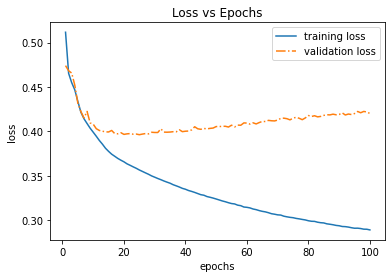

In [24]:
conv_classifier = Conv1DSentimentAnalysis(vocab_size=len(vocab), embedding_dim=embed_len, num_filters=100, filter_sizes=[3, 4, 5], hidden_dim=embed_len, num_classes=2)
conv_classifier.to(device)
ct, cv = exec_pipeline(conv_classifier)

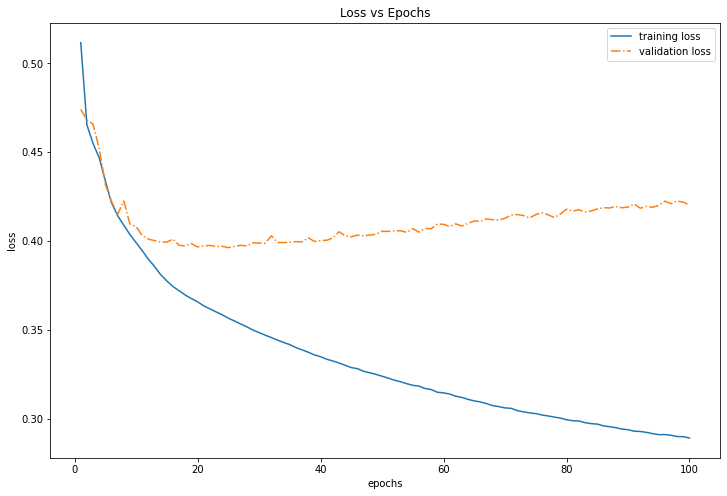

In [29]:
x = list(range(1, len(ct)+1))
tr = [i.item() for i in ct]
va = [i.item() for i in cv]

plt.figure(figsize=(12, 8))
plt.plot(x, tr, label ='training loss')
plt.plot(x, va, '-.', label ='validation loss')

plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.title('Loss vs Epochs')
plt.savefig('CNN.png')
# plt.show()

# RNN

Layer : Embedding(87086, 128)
Parameters : 
torch.Size([87086, 128])

Layer : RNN(64, 64, num_layers=3)
Parameters : 
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64])

Layer : MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
Parameters : 

Layer : Linear(in_features=128, out_features=2, bias=True)
Parameters : 
torch.Size([2, 128])
torch.Size([2])

torch.Size([1024, 2])
Epoch 1:


100%|██████████| 1272/1272 [00:48<00:00, 26.45it/s]


Train Loss : 0.62738
Valid Loss : 0.57044
Valid Acc  : 0.72812
Epoch 2:


100%|██████████| 1272/1272 [00:49<00:00, 25.93it/s]


Train Loss : 0.56105
Valid Loss : 0.55443
Valid Acc  : 0.74567
Epoch 3:


100%|██████████| 1272/1272 [00:46<00:00, 27.17it/s]


Train Loss : 0.54938
Valid Loss : 0.54373
Valid Acc  : 0.75932
Epoch 4:


100%|██████████| 1272/1272 [00:47<00:00, 26.87it/s]


Train Loss : 0.53979
Valid Loss : 0.53434
Valid Acc  : 0.77151
Epoch 5:


100%|██████████| 1272/1272 [00:48<00:00, 26.35it/s]


Train Loss : 0.53169
Valid Loss : 0.52682
Valid Acc  : 0.77731
Epoch 6:


100%|██████████| 1272/1272 [00:47<00:00, 27.00it/s]


Train Loss : 0.52487
Valid Loss : 0.52114
Valid Acc  : 0.78217
Epoch 7:


100%|██████████| 1272/1272 [00:47<00:00, 26.69it/s]


Train Loss : 0.51962
Valid Loss : 0.51818
Valid Acc  : 0.78600
Epoch 8:


100%|██████████| 1272/1272 [00:48<00:00, 26.19it/s]


Train Loss : 0.51679
Valid Loss : 0.51532
Valid Acc  : 0.78898
Epoch 9:


100%|██████████| 1272/1272 [00:47<00:00, 26.89it/s]


Train Loss : 0.51502
Valid Loss : 0.51479
Valid Acc  : 0.79016
Epoch 10:


100%|██████████| 1272/1272 [00:47<00:00, 26.88it/s]


Train Loss : 0.51349
Valid Loss : 0.51283
Valid Acc  : 0.79103
Epoch 11:


100%|██████████| 1272/1272 [00:47<00:00, 26.57it/s]


Train Loss : 0.51197
Valid Loss : 0.51302
Valid Acc  : 0.79026
Epoch 12:


100%|██████████| 1272/1272 [00:47<00:00, 26.99it/s]


Train Loss : 0.51074
Valid Loss : 0.51142
Valid Acc  : 0.79153
Epoch 13:


100%|██████████| 1272/1272 [00:47<00:00, 26.87it/s]


Train Loss : 0.50943
Valid Loss : 0.51010
Valid Acc  : 0.79386
Epoch 14:


100%|██████████| 1272/1272 [00:47<00:00, 26.85it/s]


Train Loss : 0.50806
Valid Loss : 0.50947
Valid Acc  : 0.79451
Epoch 15:


100%|██████████| 1272/1272 [00:47<00:00, 26.74it/s]


Train Loss : 0.50707
Valid Loss : 0.50924
Valid Acc  : 0.79502
Epoch 16:


100%|██████████| 1272/1272 [00:47<00:00, 26.98it/s]


Train Loss : 0.50591
Valid Loss : 0.50820
Valid Acc  : 0.79584
Epoch 17:


100%|██████████| 1272/1272 [00:47<00:00, 26.88it/s]


Train Loss : 0.50506
Valid Loss : 0.50784
Valid Acc  : 0.79663
Epoch 18:


100%|██████████| 1272/1272 [00:48<00:00, 26.21it/s]


Train Loss : 0.50422
Valid Loss : 0.50772
Valid Acc  : 0.79668
Epoch 19:


100%|██████████| 1272/1272 [00:47<00:00, 26.97it/s]


Train Loss : 0.50359
Valid Loss : 0.50784
Valid Acc  : 0.79668
Epoch 20:


100%|██████████| 1272/1272 [00:47<00:00, 26.79it/s]


Train Loss : 0.50294
Valid Loss : 0.50789
Valid Acc  : 0.79514
Epoch 21:


100%|██████████| 1272/1272 [00:48<00:00, 26.31it/s]


Train Loss : 0.50234
Valid Loss : 0.50710
Valid Acc  : 0.79735
Epoch 22:


100%|██████████| 1272/1272 [00:47<00:00, 27.02it/s]


Train Loss : 0.50196
Valid Loss : 0.50730
Valid Acc  : 0.79618
Epoch 23:


100%|██████████| 1272/1272 [00:47<00:00, 26.81it/s]


Train Loss : 0.50154
Valid Loss : 0.50659
Valid Acc  : 0.79756
Epoch 24:


100%|██████████| 1272/1272 [00:48<00:00, 26.46it/s]


Train Loss : 0.50124
Valid Loss : 0.50853
Valid Acc  : 0.79428
Epoch 25:


100%|██████████| 1272/1272 [00:47<00:00, 26.75it/s]


Train Loss : 0.50092
Valid Loss : 0.50691
Valid Acc  : 0.79785
Epoch 26:


100%|██████████| 1272/1272 [00:47<00:00, 26.83it/s]


Train Loss : 0.50039
Valid Loss : 0.50618
Valid Acc  : 0.79804
Epoch 27:


100%|██████████| 1272/1272 [00:47<00:00, 27.02it/s]


Train Loss : 0.50018
Valid Loss : 0.50683
Valid Acc  : 0.79748
Epoch 28:


100%|██████████| 1272/1272 [00:47<00:00, 26.60it/s]


Train Loss : 0.49988
Valid Loss : 0.50664
Valid Acc  : 0.79770
Epoch 29:


100%|██████████| 1272/1272 [00:47<00:00, 26.72it/s]


Train Loss : 0.49967
Valid Loss : 0.50610
Valid Acc  : 0.79838
Epoch 30:


100%|██████████| 1272/1272 [00:46<00:00, 27.09it/s]


Train Loss : 0.49955
Valid Loss : 0.50641
Valid Acc  : 0.79841
Epoch 31:


100%|██████████| 1272/1272 [00:48<00:00, 26.50it/s]


Train Loss : 0.49933
Valid Loss : 0.50684
Valid Acc  : 0.79788
Epoch 32:


100%|██████████| 1272/1272 [00:47<00:00, 26.89it/s]


Train Loss : 0.49925
Valid Loss : 0.50659
Valid Acc  : 0.79763
Epoch 33:


100%|██████████| 1272/1272 [00:47<00:00, 26.90it/s]


Train Loss : 0.49908
Valid Loss : 0.50625
Valid Acc  : 0.79796
Epoch 34:


100%|██████████| 1272/1272 [00:48<00:00, 26.22it/s]


Train Loss : 0.49895
Valid Loss : 0.50617
Valid Acc  : 0.79820
Epoch 35:


100%|██████████| 1272/1272 [00:48<00:00, 26.24it/s]


Train Loss : 0.49877
Valid Loss : 0.50647
Valid Acc  : 0.79836
Epoch 36:


100%|██████████| 1272/1272 [00:47<00:00, 26.79it/s]


Train Loss : 0.49871
Valid Loss : 0.50649
Valid Acc  : 0.79763
Epoch 37:


100%|██████████| 1272/1272 [00:49<00:00, 25.83it/s]


Train Loss : 0.49851
Valid Loss : 0.50651
Valid Acc  : 0.79781
Epoch 38:


100%|██████████| 1272/1272 [00:49<00:00, 25.52it/s]


Train Loss : 0.49845
Valid Loss : 0.50664
Valid Acc  : 0.79808
Epoch 39:


100%|██████████| 1272/1272 [00:49<00:00, 25.45it/s]


Train Loss : 0.49826
Valid Loss : 0.50692
Valid Acc  : 0.79687
Epoch 40:


100%|██████████| 1272/1272 [00:48<00:00, 26.48it/s]


Train Loss : 0.49818
Valid Loss : 0.50725
Valid Acc  : 0.79622
Epoch 41:


100%|██████████| 1272/1272 [00:48<00:00, 26.37it/s]


Train Loss : 0.49806
Valid Loss : 0.50699
Valid Acc  : 0.79692
Epoch 42:


100%|██████████| 1272/1272 [00:48<00:00, 25.96it/s]


Train Loss : 0.49802
Valid Loss : 0.50628
Valid Acc  : 0.79852
Epoch 43:


100%|██████████| 1272/1272 [00:50<00:00, 25.11it/s]


Train Loss : 0.49788
Valid Loss : 0.50640
Valid Acc  : 0.79797
Epoch 44:


100%|██████████| 1272/1272 [00:48<00:00, 26.01it/s]


Train Loss : 0.49783
Valid Loss : 0.50644
Valid Acc  : 0.79827
Epoch 45:


100%|██████████| 1272/1272 [00:47<00:00, 26.66it/s]


Train Loss : 0.49759
Valid Loss : 0.50717
Valid Acc  : 0.79657
Epoch 46:


100%|██████████| 1272/1272 [00:48<00:00, 26.42it/s]


Train Loss : 0.49778
Valid Loss : 0.50674
Valid Acc  : 0.79794
Epoch 47:


100%|██████████| 1272/1272 [00:48<00:00, 25.98it/s]


Train Loss : 0.49741
Valid Loss : 0.50657
Valid Acc  : 0.79808
Epoch 48:


100%|██████████| 1272/1272 [00:47<00:00, 26.56it/s]


Train Loss : 0.49737
Valid Loss : 0.50765
Valid Acc  : 0.79747
Epoch 49:


100%|██████████| 1272/1272 [00:48<00:00, 26.36it/s]


Train Loss : 0.49736
Valid Loss : 0.50647
Valid Acc  : 0.79786
Epoch 50:


100%|██████████| 1272/1272 [00:48<00:00, 26.32it/s]


Train Loss : 0.49724
Valid Loss : 0.50662
Valid Acc  : 0.79771


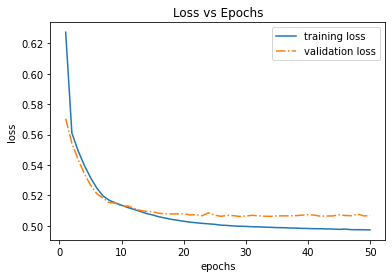

In [34]:
rnn_classifier = RNNClassifier()
rnn_classifier.to(device)
rt, rv = exec_pipeline(rnn_classifier)

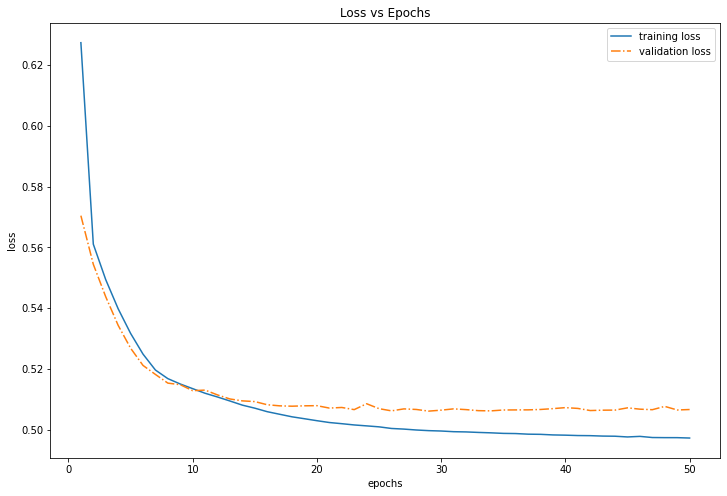

In [35]:
x = list(range(1, len(rt)+1))
tr = [i.item() for i in rt]
va = [i.item() for i in rv]

plt.figure(figsize=(12, 8))
plt.plot(x, tr, label ='training loss')
plt.plot(x, va, '-.', label ='validation loss')

plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.title('Loss vs Epochs')
plt.savefig('RNN.png')

# Logistic Regression

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

cv = CountVectorizer(binary=True, min_df = 5)
cv.fit_transform(train_data['text'].values)
train_feature_set=cv.transform(train_data['text'].values)
test_feature_set=cv.transform(test_data['text'].values)

lr = LogisticRegression(max_iter=10000, penalty="l2", n_jobs=-1)
lr.fit(train_feature_set,train_data['sentiment'])
y_pred = lr.predict(test_feature_set)
print("Accuracy: ",round(metrics.accuracy_score(test_data['sentiment'], y_pred),3))

Accuracy:  0.797


# Random Forest Classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_samples_leaf=10)
model.fit(train_feature_set,train_data['sentiment'])
predictions = model.predict(test_feature_set)
print("Accuracy: ",round(metrics.accuracy_score(test_data['sentiment'], predictions),3))

Accuracy:  0.776
